In [75]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from keras.datasets import mnist
from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from functools import partial
import keras.backend as K
import sys
from keras.datasets import mnist
import seaborn as sns

# Load and normalize MNIST dataset

In [76]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train*2./255. -1.
X_train = X_train[y_train==1]
X_test = X_test[y_test==1]

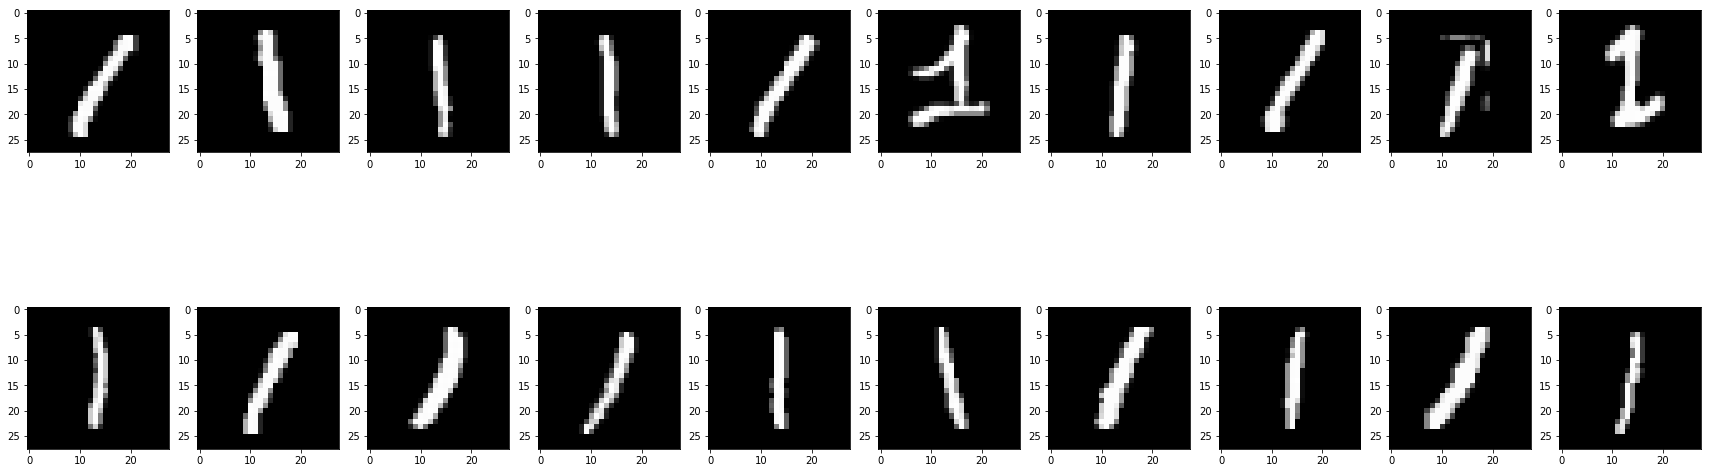

In [77]:
plt.figure(figsize=(30,10))
for ni, i in enumerate(X_train[:20]):
    plt.subplot(2,10,ni+1)
    plt.imshow((i),'gray')
plt.show()


## setup parameters

In [78]:
NUM_FEATURES=28
NUM_ONE_SAMPLE=28
latent_dim = 3
BATCH_SIZE = 100


## define generator and critic 

In [79]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)


def build_generator():

    model = Sequential()

    model.add(Dense(latent_dim))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dense(int(NUM_FEATURES*NUM_ONE_SAMPLE/2)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dense(NUM_FEATURES*NUM_ONE_SAMPLE))
    model.add(Activation("tanh"))
    model.add(Reshape((NUM_ONE_SAMPLE, NUM_FEATURES)))
    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)


def build_critic():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(NUM_FEATURES*NUM_ONE_SAMPLE))
    model.add(Activation("relu"))
    model.add(Dense(int(NUM_FEATURES*NUM_ONE_SAMPLE/2)))
    model.add(Activation("relu"))
    model.add(Dense(int(NUM_FEATURES*NUM_ONE_SAMPLE/4)))
    model.add(Activation("relu"))
    model.add(Dense(1))
    
    img = Input(shape=(NUM_ONE_SAMPLE, NUM_FEATURES,))
    validity = model(img)

    return Model(img, validity)

## define training procedures (computational graph) for critic and generator

In [80]:
#real_img, fake_img
class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        alpha = K.random_uniform((BATCH_SIZE, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])
    
def gradient_penalty_loss(y_true, y_pred, averaged_samples):
    """
    Computes gradient penalty based on prediction and weighted real / fake samples
    """
    gradients = K.gradients(y_pred, averaged_samples)[0]
    # compute the euclidean norm by squaring ...
    gradients_sqr = K.square(gradients)
    #   ... summing over the rows ...
    gradients_sqr_sum = K.sum(gradients_sqr,
                              axis=np.arange(1, len(gradients_sqr.shape)))
    #   ... and sqrt
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    # compute lambda * (1 - ||grad||)^2 still for each single sample
    gradient_penalty = K.square(1 - gradient_l2_norm)
    # return the mean as loss over all the batch samples
    return K.mean(gradient_penalty)


In [81]:
optimizer = RMSprop(lr=0.00005)

#-------------------------------
# Construct Computational Graph
#       for the Critic
#-------------------------------

generator = build_generator()
critic = build_critic()


# Image input (real sample)
real_img = Input(shape=(NUM_ONE_SAMPLE,NUM_FEATURES,))

# Noise input
z_disc = Input(shape=(latent_dim,))
# Generate image based of noise (fake sample)
fake_img = generator(z_disc)

critic = build_critic()
# Discriminator determines validity of the real and fake images
fake = critic(fake_img)
valid = critic(real_img)

critic.trainable = True
generator.trainable = False
# Construct weighted average between real and fake images
interpolated_img = RandomWeightedAverage()([real_img, fake_img])
# Determine validity of weighted sample
validity_interpolated = critic(interpolated_img)

# Use Python partial to provide loss function with additional
# 'averaged_samples' argument
partial_gp_loss = partial(gradient_penalty_loss,
                  averaged_samples=interpolated_img)
partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names



critic_model = Model(inputs=[real_img, z_disc],
                    outputs=[valid, fake, validity_interpolated])
critic_model.compile(loss=[wasserstein_loss,
                            wasserstein_loss,
                            partial_gp_loss],
                            optimizer=optimizer,
                            loss_weights=[1, 1, 10])


In [82]:
#-------------------------------
# Construct Computational Graph
#         for Generator
#-------------------------------
critic.trainable = False
generator.trainable = True
# Sampled noise for input to generator
z_gen = Input(shape=(latent_dim,))
# Generate images based of noise
img = generator(z_gen)
# Discriminator determines validity
valid = critic(img)
# Defines generator model
generator_model = Model(z_gen, valid)
generator_model.compile(loss=wasserstein_loss, optimizer=optimizer)

# Train the model

In [83]:
corr_metrics = []

In [84]:
n_critic = 2
epochs=1000
batch_size = 100
valid = -np.ones((batch_size, 1))
fke =  np.ones((batch_size, 1))
dummy = np.zeros((batch_size, 1)) # Dummy gt for gradient penalty
for epoch in tqdm(range(epochs)):
    for _ in range(n_critic):
        critic.trainable = True
        generator.trainable = False

        idx = np.random.randint(0, len(X_train), batch_size)
        data_batch = X_train[idx]
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        d_loss = critic_model.train_on_batch([data_batch, noise], [valid, fke, dummy])
    critic.trainable = False
    generator.trainable = True
    g_loss = generator_model.train_on_batch(noise, valid)
    corr_metrics.append([g_loss, d_loss])


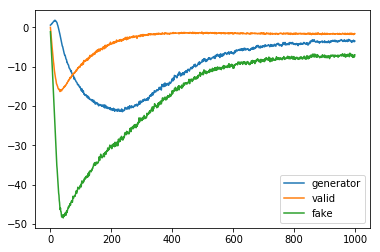

In [85]:
plt.plot(range(len(corr_metrics)), [i[0] for i in corr_metrics],label='generator')
plt.plot(range(len(corr_metrics)), [i[1][0]/2. for i in corr_metrics], label='valid')
plt.plot(range(len(corr_metrics)), [i[1][1] for i in corr_metrics], label='fake')
plt.legend()
plt.show()


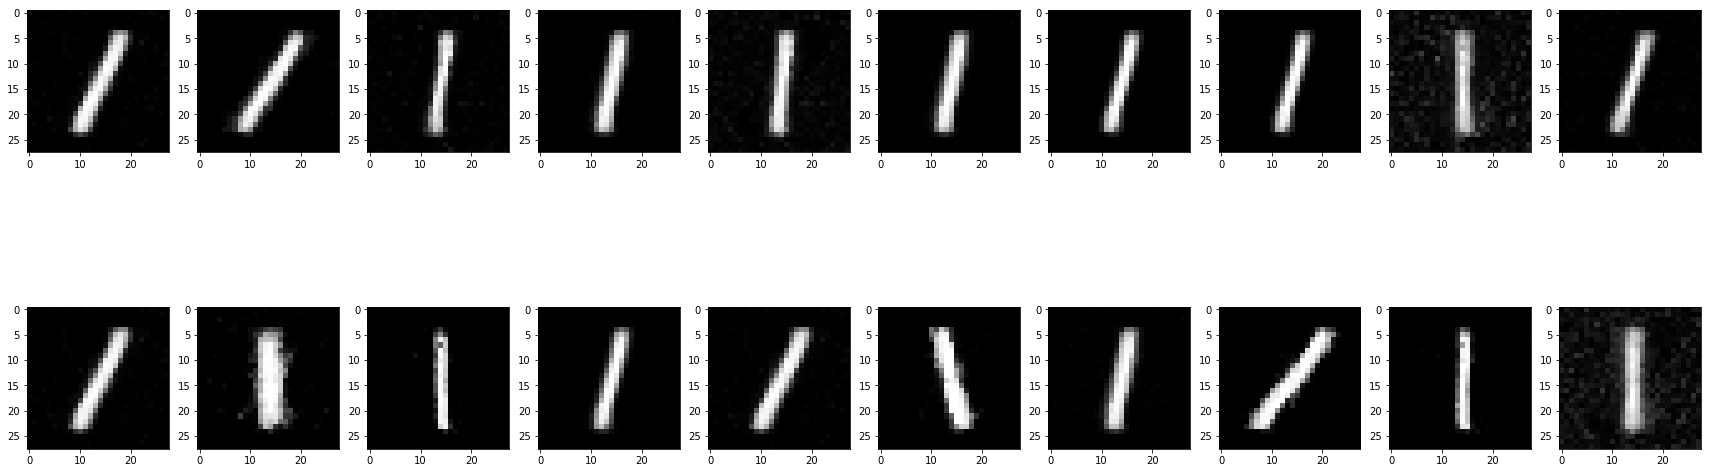

In [86]:
ar = np.random.normal(0, 1, (int(40000/NUM_ONE_SAMPLE), latent_dim))
fake = generator.predict(ar)
plt.figure(figsize=(30,10))
for ni, i in enumerate(fake[:20]):
    plt.subplot(2,10,ni+1)
    plt.imshow((i),'gray')
plt.show()